# Gesture Recognition
In this group project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Below are the libraries imported to get started with the model building.

### Git Link: 
https://github.com/shuklavaibhav1994/Gesture-Recognition/

In [1]:
#importing the required libraries
import numpy as np
import os
from skimage.transform import resize   #library for image resize
from imageio import imread   #library to read the image
import datetime
import os
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')   #to ignore the warnings

We set the random seed so that the results don't vary drastically.

In [2]:
#setting the random seed 30
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
#Using the data by mounting the google drive. Below code helps in mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this block, we are reading the csv files for training and validation. We are also setting the `batch_size` here. Note that we are setting the batch size in such a way that we are able to use the GPU in full capacity. We kept increasing the batch size until the machine thrown an error.

In [5]:
#training document path
train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/Project_data/train.csv').readlines())

#validation document path
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/Project_data/val.csv').readlines())

#setting the batch size as 20
batch_size = 20

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We have to experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

In [6]:
y = 84 # image width
z = 84 # image height

#generator function
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]   #taken alternative frames from the given 30 image frames. So total 15 frames are used.
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size  #calculate the number of batches
        for batch in range(num_batches):   #we iterate over the number of batches
            batch_data = np.zeros((batch_size,15,y,z,3))  #x is the number of images we have used for each video(in this case 15), (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5))  #batch_labels is the one hot representation of the output
            for folder in range(batch_size):  #iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])  #read all the images in the folder
                for idx,item in enumerate(img_idx):  #Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #cropped the images and resized them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    image = resize(image,(84,84))  #taken the final image size as 84*84
                    image = image/255.0   #normalising the image
                    
                    #Normalising RGB image
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        #below is the code for the remaining data points which are left after full batches

        if(len(t)%batch_size!=0):
            batch_data = np.zeros((len(t)%batch_size,15,y,z,3))  #x is the number of images we have used for each video(in this case 15), (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5))  #batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size):  #iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*(len(t)%batch_size))].split(';')[0])  #read all the images in the folder
                for idx,item in enumerate(img_idx):  #Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*(len(t)%batch_size))].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #cropped the images and resized them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    image = resize(image,(84,84))  #taken the final image size as 84*84
                    image = image/255.0   #normalising the image

                    #Normalising RGB image
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                                        
                batch_labels[folder, int(t[folder + (num_batches*(len(t)%batch_size))].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()

#taking the folder path where images are stored
train_path = '/content/drive/MyDrive/Project_data/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('Number of training sequences =', num_train_sequences)  #printing the number of training sequences 
num_val_sequences = len(val_doc)
print('Number of validation sequences =', num_val_sequences)  #printing the number of validation sequences
num_epochs = 30  #taken the number of epochs as 30
print ('# epochs =', num_epochs)

Number of training sequences = 663
Number of validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Final Model

In [8]:
#importing the required libraries

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import keras
from keras import optimizers

#writing the model here
model_3DConv = Sequential()

model_3DConv.add(Conv3D(32, kernel_size=(3,3,3), input_shape=(15, 84, 84, 3), padding='same'))
model_3DConv.add(Activation('relu'))
model_3DConv.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3DConv.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model_3DConv.add(BatchNormalization())
model_3DConv.add(Activation('relu'))
model_3DConv.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3DConv.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model_3DConv.add(BatchNormalization())
model_3DConv.add(Activation('relu'))
model_3DConv.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_3DConv.add(Dropout(0.25))

model_3DConv.add(Conv3D(128, kernel_size=(3,3,3), padding='same'))
model_3DConv.add(BatchNormalization())
model_3DConv.add(Activation('relu'))
model_3DConv.add(MaxPooling3D(pool_size=(1, 2, 2)))
model_3DConv.add(Dropout(0.25))

model_3DConv.add(Conv3D(256, kernel_size=(3,3,3), padding='same'))
model_3DConv.add(BatchNormalization())
model_3DConv.add(Activation('relu'))
model_3DConv.add(MaxPooling3D(pool_size=(1, 2, 2)))
model_3DConv.add(Dropout(0.25))

model_3DConv.add(Flatten())
model_3DConv.add(Dense(512, activation='relu'))
model_3DConv.add(Dropout(0.5))
model_3DConv.add(Dense(1024, activation='relu'))
model_3DConv.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
optimiser = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9) #write your optimizer
model_3DConv.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3DConv.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 84, 84, 32)    2624      
                                                                 
 activation (Activation)     (None, 15, 84, 84, 32)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 42, 42, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 42, 42, 64)     55360     
                                                                 
 batch_normalization (BatchN  (None, 7, 42, 42, 64)    256       
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 7, 42, 42, 64)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
#giving batch_size as 20
batch_size = 20
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
#storing the h5 files in a folder

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
history_3DConv = model_3DConv.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.9226 - categorical_accuracy: 0.3017  Source path =  /content/drive/MyDrive/Project_data/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-09-1315_55_41.784135/model-00001-1.92259-0.30166-26.21041-0.23000.h5
34/34 [==============================] - 8229s 249s/step - loss: 1.9226 - categorical_accuracy: 0.3017 - val_loss: 26.2104 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4835 - categorical_accuracy: 0.3665
Epoch 2: saving model to model_init_2022-09-1315_55_41.784135/model-00002-1.48347-0.36652-10.56100-0.26000.h5
34/34 [==============================] - 160s 5s/step - loss: 1.4835 - categorical_accuracy: 0.3665 - val_loss: 10.5610 - val_categorical_accuracy: 0.2600 - lr: 0.0100
Epoch 3/30
34/34 [==============================] - E

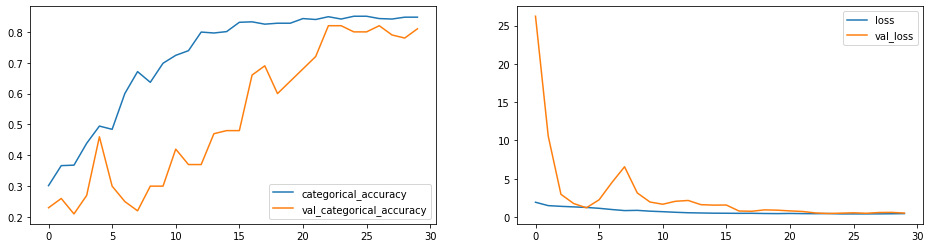

In [14]:
#plotting the graphs to check the accuracy and loss on training as well as on validation data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history_3DConv.history['categorical_accuracy'])   
axes[0].plot(history_3DConv.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history_3DConv.history['loss'])   
axes[1].plot(history_3DConv.history['val_loss'])
axes[1].legend(['loss','val_loss'])